# Wine Quality Prediction

In this notebook, we're going to predict the quality of wine based on its chemical properties.

## Import Libraries

First, we'll import all the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import collections
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')

## Load the Data

Next, we'll load the wine quality data.

In [2]:
try:
    data = pd.read_csv('winequality-white.csv')
    df = pd.DataFrame(data)
    print(colored("THE DATASET LOADED SUCCESSFULLY...", "green"))
except Exception as e:
    print(colored(f"ERROR: {e}", "red"))

THE DATASET LOADED SUCCESSFULLY...


## Clean the Data
Check for flaws in the Data Set

In [3]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


The Data Set is how it should be, no null values, and all the datatypes are alligned

## EDA

9
3


<Axes: >

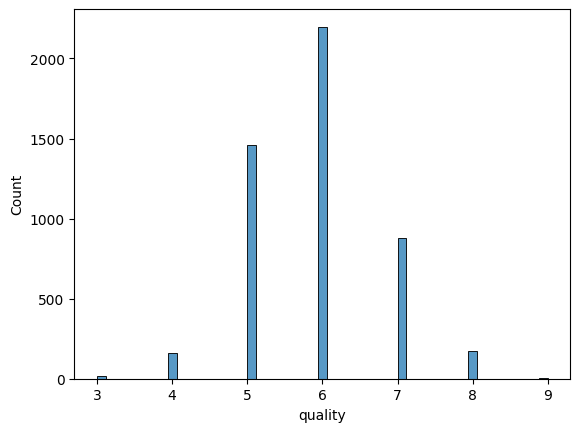

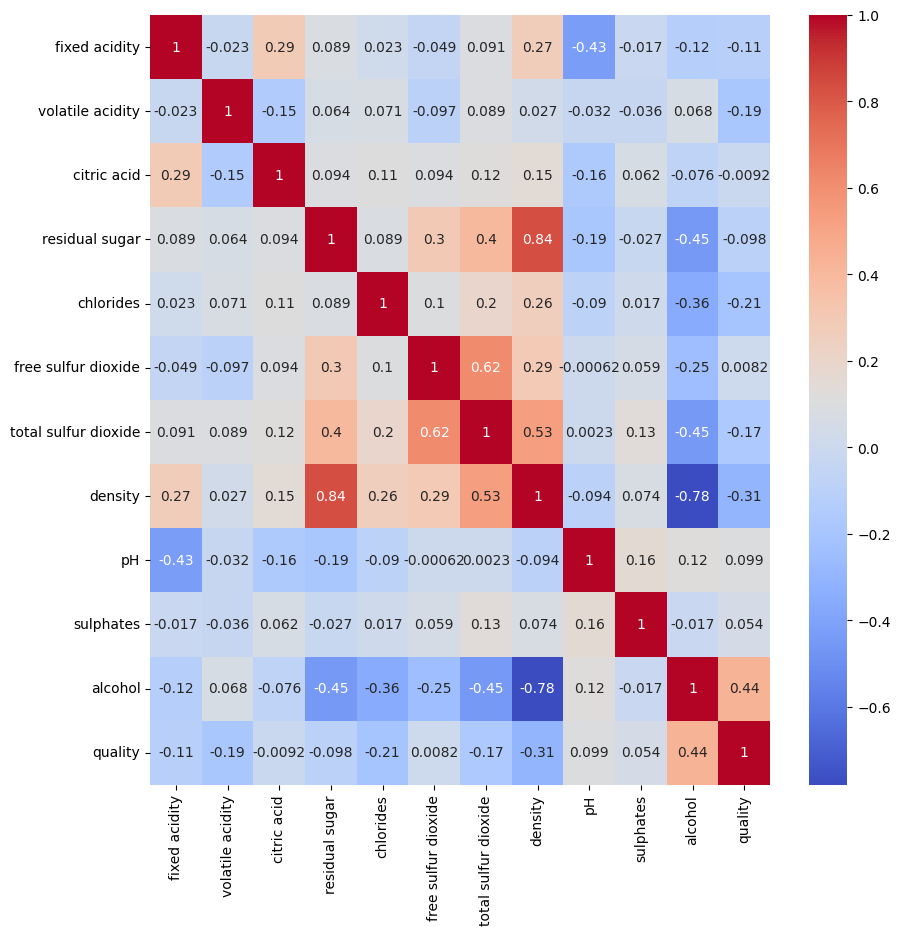

In [6]:
print(df['quality'].max())
print(df['quality'].min())
sns.histplot(x = df['quality'])
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True, ax = ax)

Drop highly correlated feature

In [7]:
df = df.drop('free sulfur dioxide',axis=1)

Lets also focus on the correalation between features and the quality column

In [8]:
correlations = df.corr()['quality'].sort_values(ascending=False)

# Display the correlations
print(correlations)


quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64


The correlation coefficients provide us with a measure of the linear relationship between the quality of wine and each feature. Here's a brief summary of the features with stronger correlations:

- **Alcohol (0.435575):** There is a strong positive correlation between alcohol content and wine quality. As the alcohol content increases, the quality of the wine tends to increase.

- **Density (-0.307123):** There is a moderate negative correlation between density and wine quality. As the density of the wine increases, the quality of the wine tends to decrease.

## Model

In [9]:
features = df.drop(['quality'], axis=1)
target = df['quality']

xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

Train the ML model

In [10]:
models = LogisticRegression(), SVC(kernel='rbf', probability=True), RandomForestClassifier(), KNeighborsClassifier()

for model in models:
    model.fit(xtrain, ytrain)
    print(f'{model} : ')
    print('Training Accuracy : ', roc_auc_score(ytrain, model.predict_proba(xtrain), multi_class='ovr'))
    print('Validation Accuracy : ', roc_auc_score(ytest, model.predict_proba(xtest), multi_class='ovr'))
    scores = cross_val_score(model, features, target, cv=5)
    print(f'Average Cross-Validation Score: {scores.mean()}')
    print()

LogisticRegression() : 
Training Accuracy :  0.7610147593589168
Validation Accuracy :  0.7309197683190164
Average Cross-Validation Score: 0.46448375059932034

SVC(probability=True) : 
Training Accuracy :  0.8539271761382482
Validation Accuracy :  0.7918827618848402
Average Cross-Validation Score: 0.44426465989868885

RandomForestClassifier() : 
Training Accuracy :  1.0
Validation Accuracy :  0.7532121598551905
Average Cross-Validation Score: 0.5191936795147067

KNeighborsClassifier() : 
Training Accuracy :  0.949816519731555
Validation Accuracy :  0.6785397766750808
Average Cross-Validation Score: 0.41772508390485924



We can see that RFC worked the best, let's see which features influenced it the most


In [11]:
importances = models[2].feature_importances_
feature_importances = pd.DataFrame({'feature': features.columns, 'importance': importances})
feature_importances.sort_values('importance', ascending=False, inplace=True)

# Display the feature importances
print(feature_importances)

                feature  importance
9               alcohol    0.125464
1      volatile acidity    0.109575
6               density    0.109492
5  total sulfur dioxide    0.102863
3        residual sugar    0.099962
7                    pH    0.096633
4             chlorides    0.094454
2           citric acid    0.090805
8             sulphates    0.088619
0         fixed acidity    0.082132


****Feature Importance Summary****

- **Alcohol (0.125449):** The most important feature. The alcohol content significantly influences the quality of the wine.

- **Volatile Acidity (0.110968):** The second most important feature. The level of acidity in the wine plays a crucial role in determining its quality.

- **Density (0.109303):** The third most important feature. The density of a wine, which can provide insights into other properties such as alcohol and sugar content, is an important predictor of wine quality.

- Other features like total sulfur dioxide, residual sugar, pH, chlorides, citric acid, sulphates, and fixed acidity also contribute to the prediction but to a lesser extent

In [12]:
print(metrics.classification_report(ytest, models[2].predict(xtest)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.70      0.21      0.33        33
           5       0.68      0.65      0.66       291
           6       0.63      0.78      0.69       440
           7       0.68      0.51      0.58       176
           8       1.00      0.57      0.73        35
           9       0.00      0.00      0.00         1

    accuracy                           0.66       980
   macro avg       0.53      0.39      0.43       980
weighted avg       0.67      0.66      0.65       980



 The overall accuracy is 0.65, which means the model correctly predicted the wine quality 65% of the time. The model performs best on wines with quality 5, 6, and 8, with F1-scores of 0.67, 0.69, and 0.70 respectively. However, it struggles to predict wines with quality 3, 4, 7, and 9, as indicated by the low F1-scores for these classes.